In [1]:
import sys, os, os.path
base = os.path.realpath("../../..")
heap = base + "/crsq-heap/src"
if (heap) not in sys.path:
    sys.path.append(heap)
    sys.path.append(base + "/crsq-arithmetic/src")
    sys.path.append(base + "/crsq-main/src")
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/hideo-t/work/py/crsq/crsq-papers/2023/.2023/lib/python3.10/site-packages', '/home/hideo-t/work/py/crsq/crsq-heap/src', '/home/hideo-t/work/py/crsq/crsq-arithmetic/src', '/home/hideo-t/work/py/crsq/crsq-main/src']


Orbital0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1


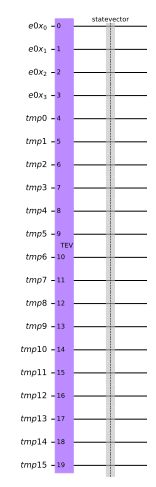

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import crsq.top.firstq as firstq
import math
import logging

# logging.basicConfig(level=logging.INFO)

m = 4               # coordinate bits
#m = 3               # coordinate bits

M = 2**m
Ne = 1              # Number of electrons
Na = 1              # Number of nuclei

d = 1               # dimension of coordinates

L=2                 # space size in one direction
delta_t = math.pi/8
dx = L/M
t = firstq.FirstQIntegrator()             # the integrator class.
t.set_dimension(d)
t.set_space_length(L)
t.set_coordinate_bits(m)
t.set_num_particles(Ne,0, Na)
t.set_use_spin(False)
t.set_mask_potential_singularity(False)
t.set_num_energy_configurations(1)
t.set_energy_configuration_weights([1])
t.set_max_particle_charge(1)
t.set_num_atom_iterations(1)
t.set_num_elec_per_atom_iterations(1)
t.set_delta_t(delta_t)
t.set_calculate_nucleus_motion(False)    # inhibit
t.set_calculate_kinetic_term(False)      # inhibit
t.set_apply_qft(False)                   # inhibit

# make electron orbital distribution data
configs = []  # 1 thermal configurations
for conf in range(1):
    electrons = []
    for elec in range(Ne):   # 2 electrons
        dims = []
        for dim in range(d):  # 1 dimension
            positions = []
            for k in range(M):
                # if (elec == 0 and k == 0):
                #     amp = 1  # electron is here.
                # elif (elec == 1 and k > 0 and k < M/2):
                if (elec == 0 and k >= 0 and k < M):
                    amp = 1  # electron is here. let the algorithm normalize the value
                else:
                    amp = 0
                positions.append(amp)
            dims.append(positions)
        # if t.should_use_spin:
        #     dims.append([1,0]) #spin. only |0>
        electrons.append(dims)
    configs.append(electrons)
t.set_initial_electron_orbitals(configs)

for k, conf in enumerate(configs[0]):
    print(f"Orbital{k}")
    for e, v in enumerate(conf[0]):
        print(e,v)
# print("Orbital1:")
# for k,v in enumerate(configs[0][0][0]):
#     print(k,v)
# print("Orbital2:")
# for k,v in enumerate(configs[0][1][0]):
#     print(k,v)

#make nucleus orbitals
configs = []
dx = L/M
for conf in range(1):
    nuclei = []
    # for nucl in range(Na):
    #     dims = []
    #     for dim in range(d):
    #         positions = []
    #         for k in range(M):
    #             if k == M//2:
    #                 amp = 1.0
    #             else:
    #                 amp = 0.0
    #             positions.append(amp)
    #         dims.append(positions)
    # nuclei.append(dims)
    configs.append(nuclei)
t.set_initial_nucleus_orbitals(configs)
t.set_nuclei_data([{"charge": 1.0, "mass": 1680, "pos": (M//2,M//2)}])

t.calculate_sizes()
t.allocate_registers()
t.build_circuit() # Go build the circuit.

circ = t.circuit()
circ.save_statevector()

t.circuit().draw('mpl', filename=f'paper_diagrams/integrator-{d}d{m}b{Ne}e{Na}n.png', scale=0.5)
#t.circuit().draw()


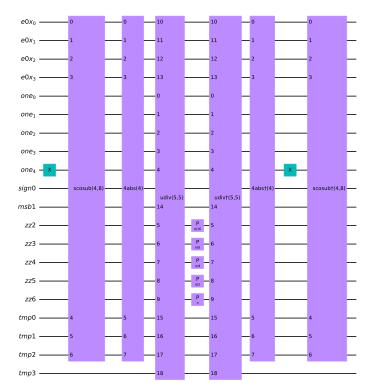

In [3]:
block = t.build_elec_potential_block()
block.circuit.draw(filename=f'paper_diagrams/H_ep-{d}d{m}b{Ne}e{Na}n',scale=0.4, fold=-1)

In [4]:
import logging
from qiskit_aer import Aer
from qiskit import transpile
import crsq.utils.statevector as svec
import crsq.arithmetic.test_tools as test_tools

#logging.basicConfig(level=logging.WARNING)

backend = Aer.get_backend('aer_simulator_statevector')
#backend = Aer.get_backend('aer_simulator_matrix_product_state')
transpiled = transpile(circ, backend)
results = backend.run(transpiled).result()
sv = results.get_statevector()
dirname="output/hamiltonian"
os.makedirs(dirname, exist_ok=True)
svec.save_to_file(f"{dirname}/e{Ne}-n{Na}.{d}d.{m}b.t{delta_t/math.pi}.x0=0.x1=1..{M/2-1}.csv", sv, eps=1e-12)

test_tools.dump_statevector_raw(sv)

00000000000000000000 : z= 0.230970+0.095671j
00000000000000000001 : z= 0.230970+0.095671j
00000000000000000010 : z= 0.230970+0.095671j
00000000000000000011 : z= 0.207867+0.138893j
00000000000000000100 : z= 0.176777+0.176777j
00000000000000000101 : z= 0.138893+0.207867j
00000000000000000110 : z= 0.000000+0.250000j
00000000000000000111 : z=-0.250000+0.000000j
00000000000000001000 : z= 0.245196-0.048773j
00000000000000001001 : z=-0.250000-0.000000j
00000000000000001010 : z=-0.000000+0.250000j
00000000000000001011 : z= 0.138893+0.207867j
00000000000000001100 : z= 0.176777+0.176777j
00000000000000001101 : z= 0.207867+0.138893j
00000000000000001110 : z= 0.230970+0.095671j
00000000000000001111 : z= 0.230970+0.095671j


In [5]:
import crsq.utils.statevector as svec

dirname="output/hamiltonian"
filename=f"{dirname}/e{Ne}-n{Na}.{d}d.{m}b.t{delta_t/math.pi}.x0=0.x1=1..{M/2-1}.csv"
print("reading from : " + filename)
sv2 = svec.read_from_file(filename)

reading from : output/hamiltonian/e1-n1.1d.4b.t0.125.x0=0.x1=1..7.0.csv


0 0.12499999999999879 0.125 0.125 1.2073675392798577e-15
1 0.12499999999999871 0.125 0.14285714285714285 0.01785714285714414
2 0.12499999999999882 0.125 0.16666666666666666 0.04166666666666784
3 0.18749999999999892 0.1875 0.2 0.012500000000001094
4 0.2499999999999986 0.25 0.25 1.3877787807814457e-15
5 0.3124999999999989 0.3125 0.3333333333333333 0.020833333333334425
6 0.4999999999999989 0.5 0.5 1.1102230246251565e-15
7 0.9999999999999989 1.0 1.0 1.1102230246251565e-15
8 1.9375000000000002 1.9375 1.9375 -2.220446049250313e-16
9 1.0 1.0 1.0 0.0
10 0.5000000000000001 0.5 0.5 -1.1102230246251565e-16
11 0.3125000000000002 0.3125 0.3333333333333333 0.020833333333333093
12 0.2500000000000001 0.25 0.25 -1.1102230246251565e-16
13 0.18750000000000025 0.1875 0.2 0.012499999999999761
14 0.12500000000000017 0.125 0.16666666666666666 0.04166666666666649
15 0.12500000000000014 0.125 0.14285714285714285 0.01785714285714271


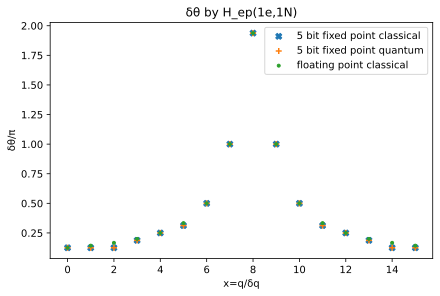

In [6]:
import matplotlib.pyplot as plt
import cmath, math

x0 = 8

def true_theta(x):
    q = dx * abs(x-x0)
    if q != 0:
        H = 1/q
    else:
        q = dx * 16/31
        H = 1/q
    theta = H*delta_t
    return theta

def expected_theta(x):
    one = int(1.0 * (2**(m)))
    r = abs(x-x0)
    if r != 0:
        int_inv_x = one // r
    else:
        int_inv_x = 2*one - 1
    inv_x = int_inv_x *(2**(-m))
    H = inv_x / dx
    theta = H * delta_t
    return theta

def modulo(th):
    return th % 2

data = sv2.to_dict()
ax = []
ay = []
aY = []
aZ = []
for xstr, y in data.items():
    x= int(xstr[-4:], base=2)
    ax.append(x)
    yarg = modulo(cmath.phase(y) / math.pi)
    ay.append(yarg)
    Z = expected_theta(x) / math.pi
    aZ.append(Z)
    Y = true_theta(x) / math.pi
    aY.append(Y)
    print (x,yarg,Z,Y, Y-yarg)

fig, axis = plt.subplots(figsize=(6,4), layout="constrained")
axis.scatter(ax, aZ, label="5 bit fixed point classical", marker="X")
axis.scatter(ax, ay, label="5 bit fixed point quantum", marker="+")
axis.scatter(ax, aY, label="floating point classical", marker=".")
axis.legend()
axis.set_xlabel("x=q/δq")
axis.set_ylabel("δθ/π")
axis.set_title("δθ by H_ep(1e,1N)")
fig.savefig("paper_diagrams/H_enp-phase.png")

INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: dimension = 1
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_coordinate_bits = 4
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: space_length = 2.000000
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_electrons = 1
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_moving_nuclei = 1
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_stationary_nuclei = 0
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: use_spin = 0
INFO:crsq.blocks.wave_function:WaveFunctionRegisterSpec: num_orbital_index_bits = 0
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: max_particle_charge = 1.000000
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: num_v_numerator_int_bits = 1
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: should_apply_potential_to_phase = 1
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: should_revert_potential_ancilla_value = 1
INFO:crsq.blocks.hamiltonian:HamiltonianSpec: should_m

Orbital0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1


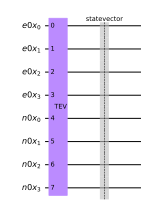

In [7]:
import crsq.top.firstq as firstq
import math
import logging
from qiskit_aer import AerSimulator

logging.basicConfig(level=logging.INFO)

m = 4               # coordinate bits
M = 2**m
Ne = 1              # Number of electrons
Na = 1              # Number of nuclei
d = 1               # dimension of coordinates
L=2                 # space size in one direction
delta_t = 2/math.pi
dx = L/M
dk = 2*math.pi/M
t = firstq.FirstQIntegrator()             # the integrator class.
t.set_dimension(d)
t.set_space_length(L)
t.set_coordinate_bits(m)
t.set_num_particles(Ne,Na)
t.set_num_energy_configurations(1)
t.set_energy_configuration_weights([1])
t.set_max_particle_charge(1)
t.set_num_atom_iterations(1)
t.set_num_elec_per_atom_iterations(1)
t.set_delta_t(delta_t)
t.set_calculate_nucleus_motion(False)    # inhibit
t.set_calculate_kinetic_term(True)      # inhibit
t.set_calculate_potential_term(False)
t.set_apply_qft(False)                   # inhibit

# make electron orbital distribution data
configs = []  # 1 thermal configurations
for conf in range(1):
    electrons = []
    for elec in range(Ne):   # 2 electrons
        dims = []
        for dim in range(d):  # 1 dimension
            positions = []
            for k in range(M):
                # if (elec == 0 and k == 0):
                #     amp = 1  # electron is here.
                # elif (elec == 1 and k > 0 and k < M/2):
                if elec == 0:
                    amp = 1  # electron is here. let the algorithm normalize the value
                else:
                    amp = 0
                positions.append(amp)
            dims.append(positions)
        electrons.append(dims)
    configs.append(electrons)
t.set_initial_electron_orbitals(configs)

for k, conf in enumerate(configs[0]):
    print(f"Orbital{k}")
    for e, v in enumerate(conf[0]):
        print(e,v)
# print("Orbital1:")
# for k,v in enumerate(configs[0][0][0]):
#     print(k,v)
# print("Orbital2:")
# for k,v in enumerate(configs[0][1][0]):
#     print(k,v)

#make nucleus orbitals
configs = []
for conf in range(1):
    nuclei = []
    for nucl in range(Na):
        dims = []
        for dim in range(d):
            positions = []
            for k in range(M):
                if k == 0:
                    amp = 1.0
                else:
                    amp = 0.0
                positions.append(amp)
            dims.append(positions)
    nuclei.append(dims)
    configs.append(nuclei)
t.set_initial_nucleus_orbitals(configs)
t.set_nuclei_data([{"charge": 1.0, "mass": 1680}])

t.calculate_sizes()
t.allocate_registers()
t.build_circuit() # Go build the circuit.

circ = t.circuit()
circ.save_statevector()

t.circuit().draw('mpl', filename=f'paper_diagrams/integrator-H_ek-{m}b{Ne}e{Na}n.png', scale=0.5)
#t.circuit().draw()


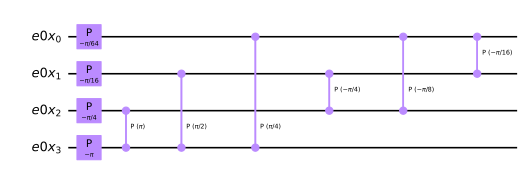

In [8]:
reg_set = t._build_elec_kinetic_step_x()
reg_set.circuit.draw(filename=f'paper_diagrams/H_ek-{m}b{Ne}e{Na}n',scale=0.8)

In [9]:
from qiskit import transpile
import crsq.utils.statevector as svec
import crsq.arithmetic.test_tools as test_tools
import logging

logging.basicConfig(level=logging.WARNING)

backend = AerSimulator(device="CPU")
transpiled = transpile(circ, backend)
results = backend.run(transpiled).result()
sv = results.get_statevector()

dirname="output/hamiltonian"
filename=f"{dirname}/He_k.e{Ne}-n{Na}.{m}b.t{delta_t*math.pi}.x=0..{M/2}.csv"
print("writing to file: " + filename)
svec.save_to_file(filename, sv, eps=1e-12)


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.01144 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00668 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 2.82669 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('p', 1), ('for_loop', 4), ('cp', 2), ('h', 1), ('save_statevector', 8)} to target basis {'u3', 'superop', 'cu2', 'cx', 'cu1', 'break_loop', 'save_probabilities', 'r', 't', 'mcx_gray', 'diagonal', 'ryy', 'save_clifford', 'cswap', 'cy', 'tdg', 'sxdg', 'mcsx', 'u1', 'initialize', 'save_matrix_product_state', 'save_state', 'mcu2', 'reset', 'sx', 'save_expval_var', 'for_loop', 'rzx', 'x', 'swap', 'rzz', 'set_matrix_product_state', 'mcrx', 'u2', 'mcu1', 'while_loop', 'rxx', 'h', 'mcz', 'cu', 'snapshot', 'measure', 'mcry', 'mcswap', 'multiplexer', 'u', 'save_unitary', 'mcr', 'kraus', 'mcu3', 'mcphase', 'i

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00739 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00858 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.91617 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('p', 1), ('barrier', 8), ('barrier', 4), ('h', 1), ('cp', 2), ('save_statevector', 8), ('mark', 4)} to target basis {'u3', 'superop', 'cu2', 'cx', 'cu1', 'break_loop', 'save_probabilities', 'r', 't', 'mcx_gray', 'diagonal', 'ryy', 'save_clifford', 'cswap', 'cy', 'tdg', 'sxdg', 'mcsx', 'u1', 'initialize', 'save_matrix_product_state', 'save_state', 'mcu2', 'reset', 'sx', 'save_expval_var', 'for_loop', 'rzx', 'x', 'swap', 'rzz', 'set_matrix_product_state', 'mcrx', 'u2', 'mcu1', 'while_loop', 'rxx', 'h', 'mcz', 'cu', 'snapshot', 'measure', 'mcry', 'mark', 'mcswap', 'multiplexer', 'u', 'save_unitary', 'mcr', 'kraus', 'mcu3', 'mcphase', 'id', 'jump', 's', 'save_amplitudes', 'uni

writing to file: output/hamiltonian/He_k.e1-n1.4b.t2.0.x=0..8.0.csv


In [10]:
test_tools.dump_statevector_raw(sv)

00000000 : z= 0.250000+0.000000j
00000001 : z= 0.249699-0.012267j
00000010 : z= 0.245196-0.048773j
00000011 : z= 0.225997-0.106889j
00000100 : z= 0.176777-0.176777j
00000101 : z= 0.084222-0.235386j
00000110 : z=-0.048773-0.245196j
00000111 : z=-0.185238-0.167890j
00001000 : z=-0.250000-0.000000j
00001001 : z=-0.185238-0.167890j
00001010 : z=-0.048773-0.245196j
00001011 : z= 0.084222-0.235386j
00001100 : z= 0.176777-0.176777j
00001101 : z= 0.225997-0.106889j
00001110 : z= 0.245196-0.048773j
00001111 : z= 0.249699-0.012267j


0 0.0 -0.0 -0.0 -0.0
1 -0.015625000000000003 -0.015625 -0.015625 3.469446951953614e-18
2 -0.0625 -0.0625 -0.0625 0.0
3 -0.140625 -0.14062500000000003 -0.14062500000000003 -2.7755575615628914e-17
4 -0.25 -0.25 -0.25 0.0
5 -0.390625 -0.390625 -0.390625 0.0
6 -0.5624999999999999 -0.5625000000000001 -0.5625000000000001 -2.220446049250313e-16
7 -0.765625 -0.7656250000000001 -0.7656250000000001 -1.1102230246251565e-16
-8 -1.0 -1.0 -1.0 0.0
-7 -0.7656250000000001 -0.7656250000000001 -0.7656250000000001 0.0
-6 -0.5625 -0.5625000000000001 -0.5625000000000001 -1.1102230246251565e-16
-5 -0.390625 -0.390625 -0.390625 0.0
-4 -0.25 -0.25 -0.25 0.0
-3 -0.14062500000000003 -0.14062500000000003 -0.14062500000000003 0.0
-2 -0.06249999999999997 -0.0625 -0.0625 -2.7755575615628914e-17
-1 -0.015624999999999962 -0.015625 -0.015625 -3.8163916471489756e-17


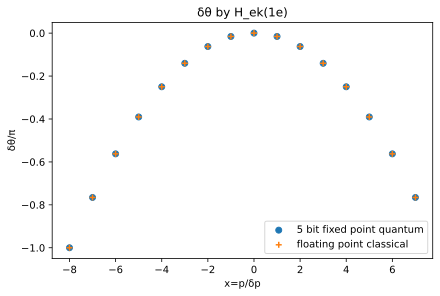

In [11]:
import matplotlib.pyplot as plt
import cmath, math

def true_theta(x):
    p = dk * x
    H = p*p/2
    theta = -H*delta_t
    return theta

def expected_theta(x):
    p = dk * x
    H = p*p/2
    theta = -H*delta_t
    return theta

data = sv.to_dict()
ax = []
ay = []
aY = []
aZ = []
for xstr, y in data.items():
    x= int(xstr[-3:], base=2) - int(xstr[-4:-3] + '000', base=2)
    ax.append(x)
    yarg = cmath.phase(y) / math.pi
    ay.append(yarg)
    Z = expected_theta(x) / math.pi
    aZ.append(Z)
    Y = true_theta(x) / math.pi
    aY.append(Y)
    print (x,yarg,Z,Y, Y-yarg)

fig, axis = plt.subplots(figsize=(6,4), layout="constrained")
axis.scatter(ax, ay, label="5 bit fixed point quantum", marker="o")
axis.scatter(ax, aY, label="floating point classical", marker="+")
axis.legend()
axis.set_xlabel("x=p/δp")
axis.set_ylabel("δθ/π")
axis.set_title("δθ by H_ek(1e)")
fig.savefig("paper_diagrams/H_ek-phase.png")

output/hamiltonian/e1-n1.1d.4b.t0.125.x0=0.x1=1..7.0.csv
0 0.12499999999999879 0.125 0.125 1.2073675392798577e-15
1 0.12499999999999871 0.125 0.14285714285714285 0.01785714285714414
2 0.12499999999999882 0.125 0.16666666666666666 0.04166666666666784
3 0.18749999999999892 0.1875 0.2 0.012500000000001094
4 0.2499999999999986 0.25 0.25 1.3877787807814457e-15
5 0.3124999999999989 0.3125 0.3333333333333333 0.020833333333334425
6 0.4999999999999989 0.5 0.5 1.1102230246251565e-15
7 0.9999999999999989 1.0 1.0 1.1102230246251565e-15
8 1.9375000000000002 1.9375 1.9375 -2.220446049250313e-16
9 1.0 1.0 1.0 0.0
10 0.5000000000000001 0.5 0.5 -1.1102230246251565e-16
11 0.3125000000000002 0.3125 0.3333333333333333 0.020833333333333093
12 0.2500000000000001 0.25 0.25 -1.1102230246251565e-16
13 0.18750000000000025 0.1875 0.2 0.012499999999999761
14 0.12500000000000017 0.125 0.16666666666666666 0.04166666666666649
15 0.12500000000000014 0.125 0.14285714285714285 0.01785714285714271
reading from : output/

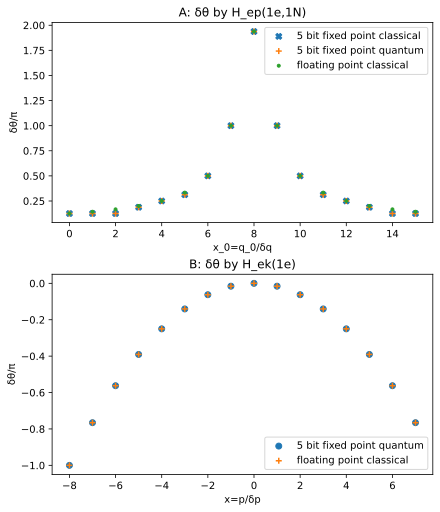

In [12]:
import crsq.utils.statevector as svec
import math
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(6,7), dpi=300, layout="constrained")


m = 4               # coordinate bits
M = 2**m
Ne = 1              # Number of electrons
Na = 1              # Number of nuclei
d = 1               # dimension of coordinates
L=2                 # space size in one direction
dx = L/M
dk = 2*math.pi/M
delta_t = math.pi/8
dirname="output/hamiltonian"
filename = f"{dirname}/e{Ne}-n{Na}.{d}d.{m}b.t{delta_t/math.pi}.x0=0.x1=1..{M/2-1}.csv"
print(filename)
sv2 = svec.read_from_file(filename)
import matplotlib.pyplot as plt
import cmath, math

def true_theta(x):
    q = dx * abs(x-x0)
    if q != 0:
        H = 1/q
    else:
        q = dx * 16/31
        H = 1/q
    theta = H*delta_t
    return theta

def expected_theta(x):
    one = int(1.0 * (2**(m)))
    r = abs(x-x0)
    if r != 0:
        int_inv_x = one // r
    else:
        int_inv_x = 2*one - 1
    inv_x = int_inv_x *(2**(-m))
    H = inv_x / dx
    theta = H * delta_t
    return theta

def modulo(th):
    return th % 2

data = sv2.to_dict()
ax = []
ay = []
aY = []
aZ = []
for xstr, y in data.items():
    x= int(xstr[-4:], base=2)
    ax.append(x)
    yarg = modulo(cmath.phase(y) / math.pi)
    ay.append(yarg)
    Z = expected_theta(x) / math.pi
    aZ.append(Z)
    Y = true_theta(x) / math.pi
    aY.append(Y)
    print (x,yarg,Z,Y, Y-yarg)

axis = axs[0]
axis.scatter(ax, aZ, label="5 bit fixed point classical", marker="X")
axis.scatter(ax, ay, label="5 bit fixed point quantum", marker="+")
axis.scatter(ax, aY, label="floating point classical", marker=".")
axis.legend()
axis.set_xlabel("x_0=q_0/δq")
axis.set_ylabel("δθ/π")
axis.set_title("A: δθ by H_ep(1e,1N)")



m = 4               # coordinate bits
M = 2**m
Ne = 1              # Number of electrons
Na = 1              # Number of nuclei
d = 1               # dimension of coordinates
L=2                 # space size in one direction
delta_t = 2/math.pi

filename = f"{dirname}/He_k.e{Ne}-n{Na}.{m}b.t{delta_t*math.pi}.x=0..{M/2}.csv"
print("reading from : " + filename)
sv = svec.read_from_file(filename)

def true_theta(x):
    p = dk * x
    H = p*p/2
    theta = -H*delta_t
    return theta

def expected_theta(x):
    p = dk * x
    H = p*p/2
    theta = -H*delta_t
    return theta

data = sv.to_dict()
ax = []
ay = []
aY = []
aZ = []
for xstr, y in data.items():
    x= int(xstr[-3:], base=2) - int(xstr[-4:-3] + '000', base=2)
    ax.append(x)
    yarg = cmath.phase(y) / math.pi
    ay.append(yarg)
    Z = expected_theta(x) / math.pi
    aZ.append(Z)
    Y = true_theta(x) / math.pi
    aY.append(Y)
    print (x,yarg,Z,Y, Y-yarg)

axis = axs[1]
axis.scatter(ax, ay, label="5 bit fixed point quantum", marker="o")
axis.scatter(ax, aY, label="floating point classical", marker="+")
axis.legend()
axis.set_xlabel("x=p/δp")
axis.set_ylabel("δθ/π")
axis.set_title("B: δθ by H_ek(1e)")

fig.savefig("paper_diagrams/Θ_ep-Θ-ek-phase.png")